In [1]:
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sn
import os

from tensorflow.keras.layers import Input,Dense,Bidirectional,Conv2D,MaxPooling2D,Flatten,concatenate,GlobalAveragePooling2D,BatchNormalization,Lambda,Add,Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow.keras.backend as K

from transformers import AutoTokenizer, TFAutoModel, TFBertModel, logging

from utilities import *

logging.set_verbosity_error()

In [2]:
train=pd.read_csv('train_final.csv',index_col=[0]).fillna(' ')
test=pd.read_csv('test_final.csv', index_col=[0]).fillna(' ')

In [7]:
+len(test)

1281

In [3]:
def class_block(inputs):
    X = tf.keras.layers.BatchNormalization()(inputs)
    X = tf.keras.layers.Dense(512, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.Dense(128, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    
    y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(X)  # 3 labels due to three sentiment classes

    return y

In [4]:
#optimizer = tf.keras.optimizers.Adam(0.0001)
# Define configuration parameters
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)


optimizer= tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
iterations=30

seq_len=50
seq_len2=10

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


model=  "unideeplearning/polibert_sa"
tokenizer = AutoTokenizer.from_pretrained(model)
bert = TFBertModel.from_pretrained(model)

CNN = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=False, classes=3)

In [5]:
dataset = df_to_tf_data(df=train, tokenizer=tokenizer, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=True, imtxt=True, image=True, shuffle=True)

valset= df_to_tf_data(df=test, tokenizer=tokenizer, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=True, imtxt=True, image=True, shuffle=False)

In [6]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
input_ids2 = tf.keras.layers.Input(shape=(seq_len2,), name='input_ids2', dtype='int32')
mask2 = tf.keras.layers.Input(shape=(seq_len2,), name='attention_mask2', dtype='int32')

input_ids_c=tf.keras.layers.concatenate([input_ids, input_ids2])
mask_c=tf.keras.layers.concatenate([mask, mask2])

image_inputs=tf.keras.layers.Input(shape=(224,224,3),name="images")

text_embeddings = bert(input_ids_c, attention_mask=mask_c)[0]  # we only keep tensor 0 (last_hidden_state)
text_1d = tf.keras.layers.GlobalMaxPool1D()(text_embeddings)  # reduce tensor dimensionality

image_embeddings=CNN(image_inputs)
image_1d=GlobalAveragePooling2D()(image_embeddings)

X=tf.keras.layers.concatenate([text_1d, image_1d])

y=class_block(X)

model = tf.keras.Model(inputs=[input_ids, mask,input_ids2, mask2, image_inputs], outputs=y)

# freeze the DistilBERT layer
model.layers[7].trainable = False
model.layers[8].trainable = False

In [7]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_ids2 (InputLayer)         [(None, 10)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask2 (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

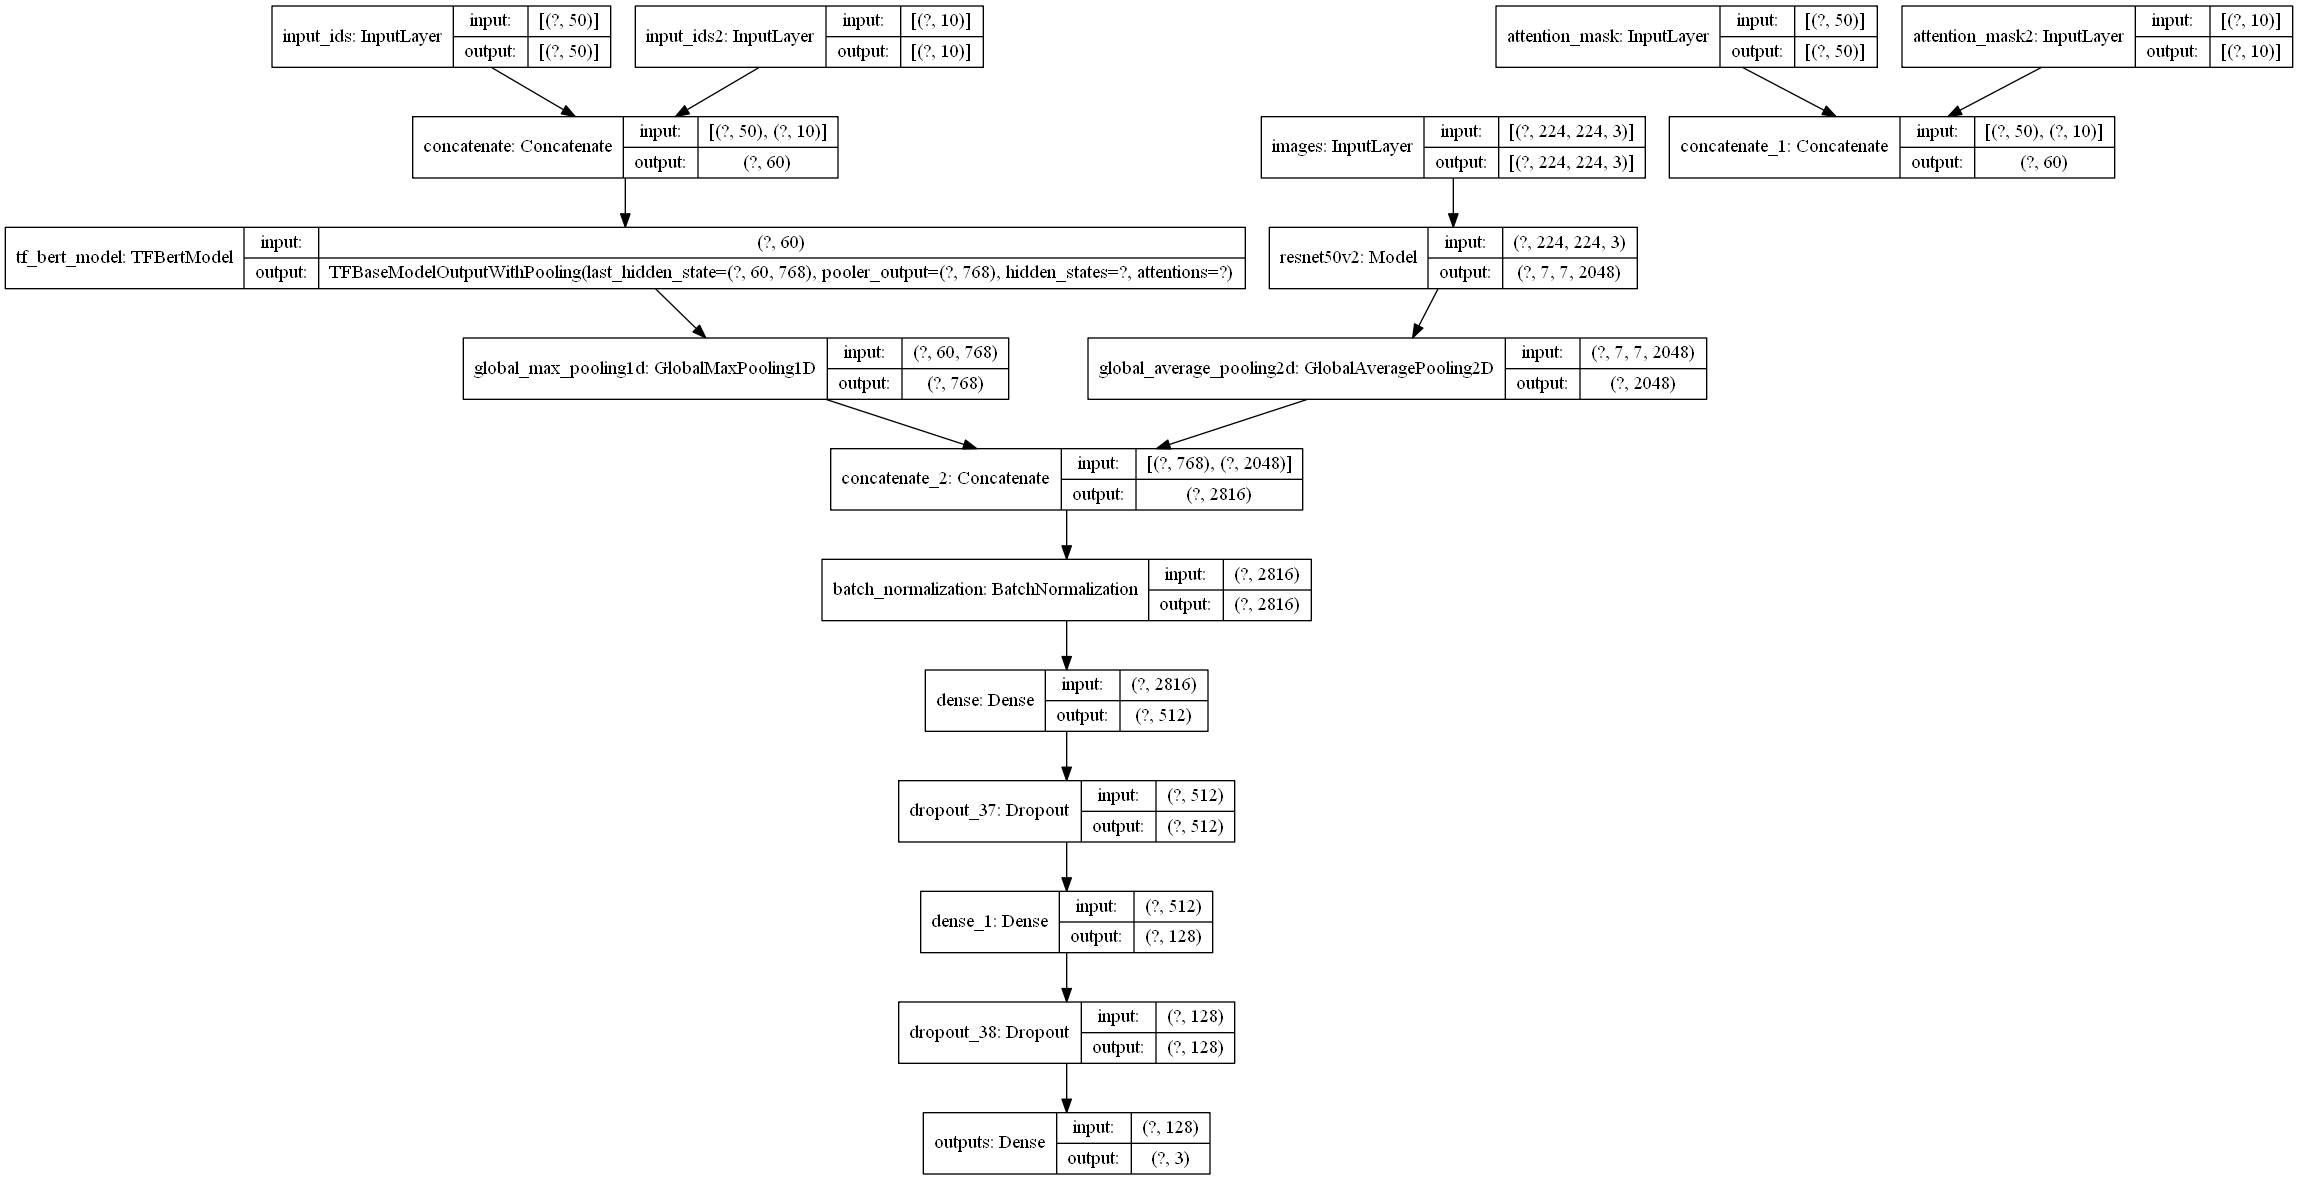

In [8]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
tf.keras.utils.plot_model(model, to_file='final_model.png', show_shapes=True)

In [ ]:
#history = model.fit(dataset,validation_data=valset, epochs=3, callbacks=[model_checkpoint_callback])

In [9]:
model.load_weights(checkpoint_filepath)

In [ ]:
#model.save_weights('saves/final_weights')

In [10]:
model.load_weights('saves/final_weights')

In [11]:
y_pred=model.predict(valset); y_true = np.concatenate([y for x, y in valset], axis=0)
y_pred_n=np.argmax(y_pred, axis=1); y_true_n= np.argmax(y_true, axis=1)




In [12]:
test2=test.copy(); test2['pred']=y_pred_n; test2['pred']=y_pred_n; test2['pred_raw']=list(y_pred)

In [13]:
test2.head(100)

,id,text,sentiment,path,hashtag,inimagetext,pred,pred_raw
0,1285259740096987136,o mi ridate la mia ship del cuore Monica e Nic...,negative,..\data\chediociaiuti\images\12852597400969871...,chediociaiuti,CLqulieg,0,"[0.49424797, 0.07401445, 0.43173763]"
1,1260491626432077824,"Sappiate cari prof, cari autori, cara giuria.....",negative,..\data\amici19\images\1260491626432077824.png,amici19,Ninln,0,"[0.9028169, 0.020035932, 0.077147104]"
2,1320118291399049219,Ma il marito non era quello coinvolto nella st...,negative,..\data\ballandoconlestelle\images\13201182913...,ballandoconlestelle,,0,"[0.81616163, 0.17230684, 0.011531576]"
3,1103773030210289664,"Gin, ma ci sei o ce la fai?!? 🤦🏻‍♀️\n #CheDioC...",negative,..\data\chediociaiuti\images\11037730302102896...,chediociaiuti,CI SEI,0,"[0.46429166, 0.43562955, 0.10007881]"
4,1218236128148455425,La storia tra Guido e azzurra doveva finire c...,negative,..\data\chediociaiuti\images\12182361281484554...,chediociaiuti,,0,"[0.91922486, 0.01811888, 0.06265627]"
...,...,...,...,...,...,...,...,...
95,1320117801386991620,"No ma, ci interessano un sacco gli aneddoti fa...",negative,..\data\ballandoconlestelle\images\13201178013...,ballandoconlestelle,,1,"[0.05938297, 0.72415525, 0.21646175]"
96,1320679878128291840,Un amico mi chiede: ma la Pellegrino perché vi...,negative,..\data\ballandoconlestelle\images\13206798781...,ballandoconlestelle,,0,"[0.46819946, 0.4587084, 0.07309217]"
97,1320121224886931456,#BallandoConLeStelle Rossella se io trovo un c...,negative,..\data\ballandoconlestelle\images\13201212248...,ballandoconlestelle,MA CHE STAI A DII,0,"[0.7591343, 0.18305407, 0.057811625]"
98,1110496663922188290,@CheDioCiAiuti_5 Anche se dovremo aspettare da...,negative,..\data\chediociaiuti\images\11104966639221882...,chediociaiuti,CHE DIO GI AIUTI,0,"[0.93103546, 0.006655527, 0.06230908]"


In [14]:
predictions=test2.replace({'pred':{0: 'negative', 1: 'neutral', 2: 'positive'}})

In [21]:
predictions.to_csv('predict.csv', index=False)

In [26]:
predictions=pd.read_csv('predict.csv', index_col=[0])

In [27]:
errors=predictions[predictions['sentiment']!=predictions['pred']]
errors=errors.reset_index()

In [28]:
colorz=[sn.color_palette("hls", 10)[0], sn.color_palette("hls", 10)[1], sn.color_palette("hls", 10)[4]]

In [29]:
list(map(float,(errors['pred_raw'][0].replace('[', ' ').replace(']', ' ').split())))


[0.14524831, 0.4471147, 0.40763703]

In [30]:
errors

,id,text,sentiment,path,hashtag,inimagetext,pred,pred_raw
0,1272525228489523202,Se tendete l’orecchio potete sentire il mio cu...,negative,..\data\amici19\images\1272525228489523202.png,amici19,iaviufficialeBi AE AldezioAhadInvia messaggio,neutral,[0.14524831 0.4471147 0.40763703]
1,1173349448816189441,La coppia più bella delle serie tv. \n\nSono r...,negative,..\data\chediociaiuti\images\11733494488161894...,chediociaiuti,j x,positive,[0.12466657 0.0579197 0.81741375]
2,1320118103435522051,Devastati mentali che per vivere hanno disogno...,negative,..\data\ballandoconlestelle\images\13201181034...,ballandoconlestelle,silosSTRUNZ,positive,[0.29646236 0.01720939 0.68632823]
3,1320101803367817216,Mariotto dà 10 perché ha visto che Costantino ...,negative,..\data\ballandoconlestelle\images\13201018033...,ballandoconlestelle,NON NE POTEVO PIU,positive,[0.2059824 0.06862482 0.72539276]
4,1320102394362056713,L’ego di Selvaggia #BallandoConLeStelle https:...,negative,..\data\ballandoconlestelle\images\13201023943...,ballandoconlestelle,id TendiStai in questo pianeta o no,positive,[0.44986844 0.07890713 0.4712245 ]
...,...,...,...,...,...,...,...,...
430,1256233543597989893,Ci sarà un tempo per ricominciare\nper dimenti...,positive,..\data\amici19\images\1256233543597989893.png,amici19,camic ir BraniCamice biancoO,neutral,[0.03217862 0.80739206 0.16042937]
431,1257698522125737985,Solo io sono così sotto a da andare ogni dieci...,positive,..\data\amici19\images\1257698522125737985.png,amici19,DIS PMLILIn arrivo maggioDr Celti licet EtDO i...,negative,[0.77886164 0.13735929 0.08377904]
432,1280986094570438657,TOP 15 INEDITI DEI RAGAZZI DI AMICI19\n\n#2\n🏆...,positive,..\data\amici19\images\1280986094570438657.png,amici19,imoPloy,neutral,[0.01195883 0.9446241 0.043417 ]
433,1256168308824514560,ANDATE A STREAMMARE MEGLIO STAR DA SOLI E INAD...,positive,..\data\amici19\images\1256168308824514560.png,amici19,,negative,[0.9711807 0.00282168 0.02599774]


JACOPO VUOI ESSERE IL MIO CONGIUNTO?
#Amici19 https://t.co/SpzAlRRCgK


TRUE LABEL:  positive 
PREDICTED LABEL:  neutral


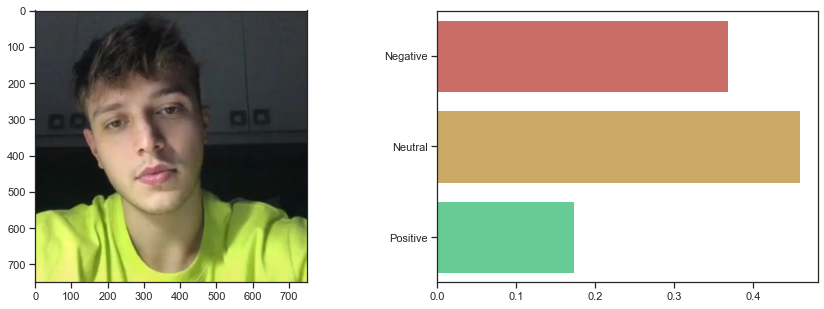

In [152]:
num=380
print(errors['text'][num])
print('\n\nTRUE LABEL: ', errors['sentiment'][num],'\nPREDICTED LABEL: ', errors['pred'][num])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.imshow(np.array(Image.open(errors['path'][num])))
sn.set_theme(style="ticks")
pred=list(map(float,(errors['pred_raw'][num].replace('[', ' ').replace(']', ' ').split())))
sn.barplot(x=pred,y=['Negative','Neutral','Positive'] , palette=colorz, orient='h')
plt.show()